# 3.1  Part A: Implementing Convolutional Neural Network from scratch.

 # Image Classification for 27 Classes Using CNNs and Transfer Learning
This notebook implements a step-by-step image classification project. It builds (a) a baseline CNN model, (b) a deeper regularized CNN, and (c) a fine-tuned ResNet50-based model.

 **Dataset Description**:  
 - **Source:** https://data.mendeley.com/datasets/w86hvkrzc5/2
 - **Type:** 27 classes (each folder represents one class).
 - **Purpose:** Image classification task required by the assignment.

 **Directory Structure Assumption:**

 ```plaintext
 ./dataset/
     class1/
         img001.jpg
         img002.jpg
         ...
     class2/
         img001.jpg
         ...
     ...
     class27/
         ...
 ```


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Set the paths
zip_path = '/content/drive/MyDrive/balanced_dataset01.zip'  # your zip file
extract_to_path = '/content/unzipped_balanced_dataset01'  # where you want to keep unzipped folder

# Create the target folder if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Extracted to: {extract_to_path}")


Extracted to: /content/unzipped_balanced_dataset01


In [ ]:
!pip install -U albumentations

 ## Task 3.1.1 - Data Understanding, Analysis, Visualization, and Cleaning

 ### Data Preprocessing and Augmentation

 We will:
 - Display a brief description of the dataset.
 - Analyze the class distribution.
 - Split data into training and validation (80-20 split).
 - Preprocess images: resize to 150×150 for CNN models (ResNet50 requires 224×224 later).
 - Augment training data to help reduce overfitting.

In [ ]:
import os
import random
import shutil
from torchvision import transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np # Added import for numpy

# Set paths
original_data_path = '/content/dataset/train-set'
new_data_path = '/content/balanced_dataset01'

# Target per class
TARGET_IMAGES = 8000

# Define augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    ToTensorV2()
])


def augment_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    augmented = augment(image=image)
    # Convert the PyTorch tensor to a NumPy array before calling .astype()
    augmented_image_np = augmented['image'].permute(1, 2, 0).cpu().numpy()
    return Image.fromarray(augmented_image_np.astype(np.uint8)) #astype(np.uint8) added


# Make new dataset directory
os.makedirs(new_data_path, exist_ok=True)

for class_name in os.listdir(original_data_path):
    class_path = os.path.join(original_data_path, class_name)
    images = os.listdir(class_path)

    class_new_path = os.path.join(new_data_path, class_name)
    os.makedirs(class_new_path, exist_ok=True)

    if len(images) >= TARGET_IMAGES:
        # UNDERSAMPLE
        selected_images = random.sample(images, TARGET_IMAGES)
        for img_name in selected_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(class_new_path, img_name)
            shutil.copy(src, dst)
    else:
        # COPY existing images first
        for img_name in images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(class_new_path, img_name)
            shutil.copy(src, dst)

        # AUGMENT until target
        while len(os.listdir(class_new_path)) < TARGET_IMAGES:
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            augmented_img = augment_image(img_path)

            new_name = f"aug_{random.randint(0,999999)}_{img_name}"
            augmented_img.save(os.path.join(class_new_path, new_name))

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


**✅ 1. Class Distribution Bar Chart**

<ipython-input-4-060bd59fcc89>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Set3")


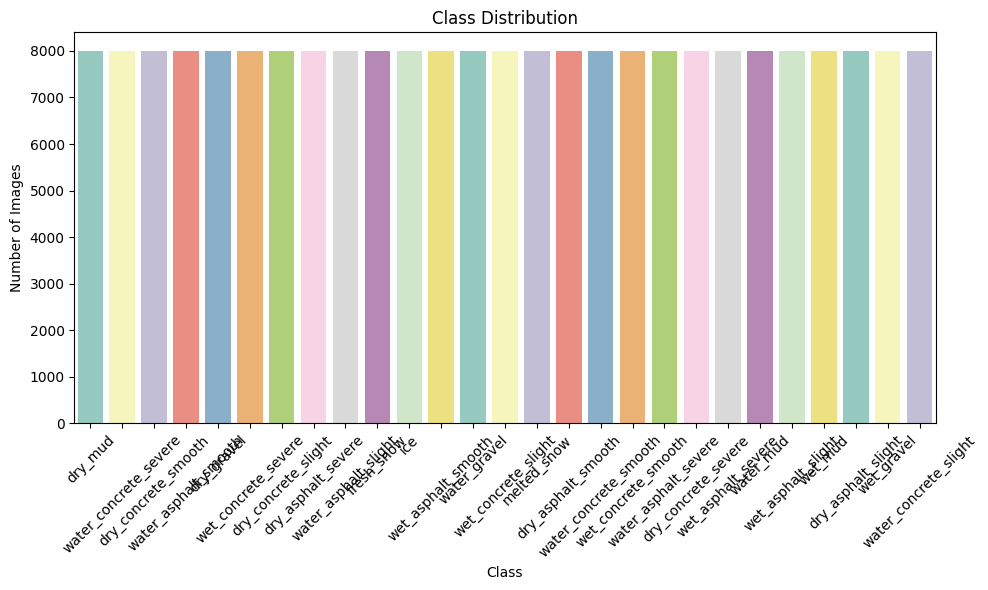

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "/content/unzipped_balanced_dataset01"  # update with your path
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Set3")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**✅ 2. Sample Image Grid**

In [ ]:
import shutil

shutil.make_archive('/content/balanced_dataset01', 'zip', '/content/balanced_dataset01')


'/content/balanced_dataset01.zip'

In [ ]:
from google.colab import files

files.download('/content/balanced_dataset01.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

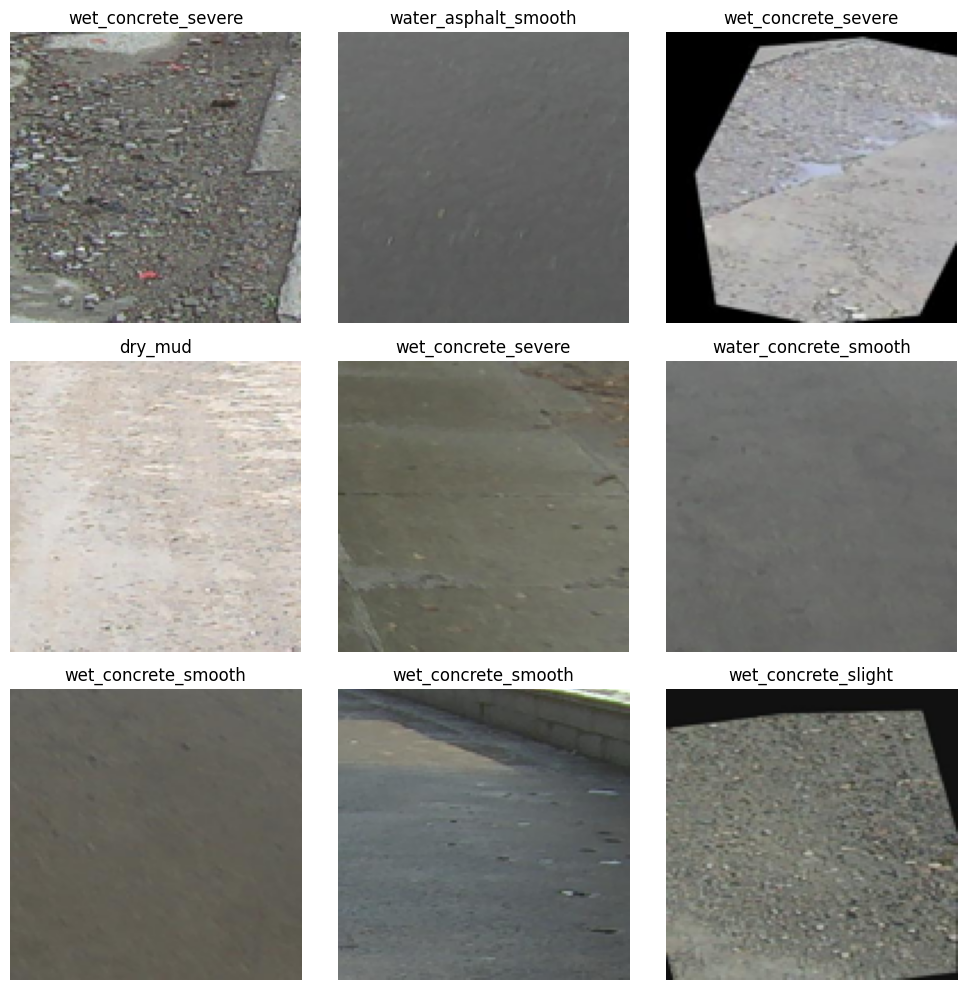

In [ ]:
from PIL import Image
import random
import os

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

classes = list(class_counts.keys())
for i in range(rows):
    for j in range(cols):
        cls = random.choice(classes)
        # Get a list of only image files within the class directory
        image_files = [f for f in os.listdir(os.path.join(data_dir, cls)) if os.path.isfile(os.path.join(data_dir, cls, f))]
        # Choose a random image file
        img_path = random.choice(image_files)
        img = Image.open(os.path.join(data_dir, cls, img_path)).resize((128, 128))
        axes[i, j].imshow(img)
        axes[i, j].set_title(cls)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

**✅ 3. Image Resolution Histogram**

**✅ 4. Color Intensity Histogram**

**✅ 5. t-SNE Visualization (Advanced)**

**Check if any corrupted image**

In [ ]:
from PIL import Image
import os

def is_image_corrupted_and_remove(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except Exception as e:
        print(f"[DELETING CORRUPTED] {image_path} → {e}")
        os.remove(image_path)  # Delete corrupted image
        return True

def check_and_clean_images(root_folder):
    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif")):
                image_path = os.path.join(dirpath, filename)
                is_image_corrupted_and_remove(image_path)

# Example usage
check_and_clean_images("/content/dataset/train-set")


In [2]:
# ! unzip "/content/drive/MyDrive/archive.zip"

In [3]:
! unzip "/content/drive/MyDrive/train-set-5k.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train-set-5k/wet_mud/2022012716253911-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/2022012716285719-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/2022012716305412-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/2022012716305419-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271647526-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271700446-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271704166-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271706426-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271707106-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271708176-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271710406-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271710417-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271711356-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201272010346-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201272021096

Total files: 135000
Training files: 108000 (80.0%)
Validation files: 13500 (10.0%)
Test files: 13500 (10.0%)


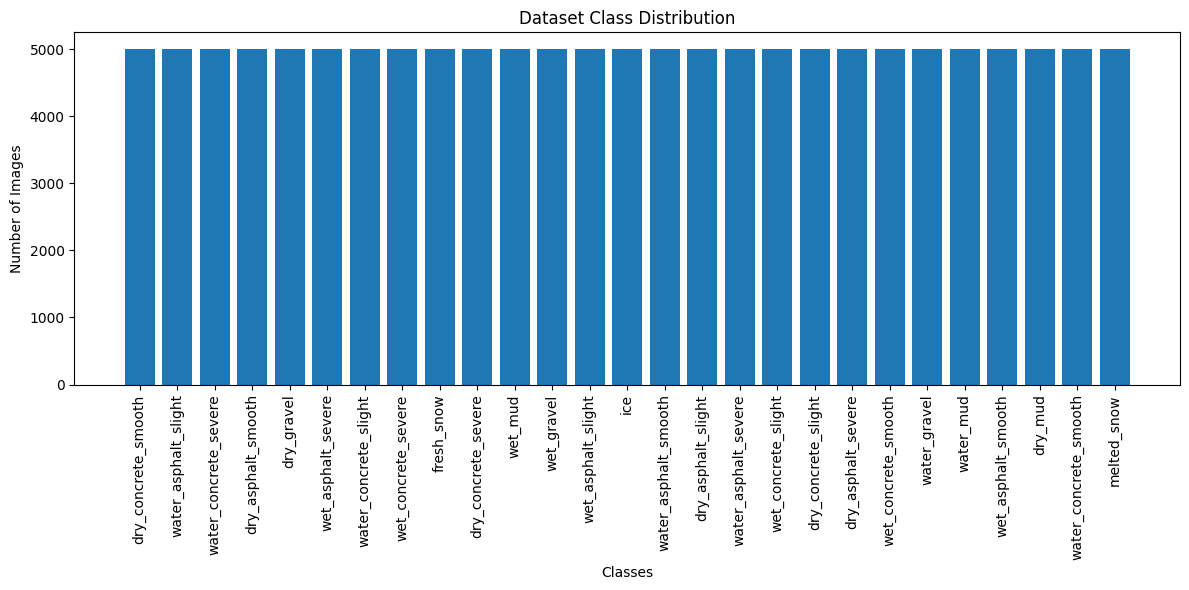

Found 108000 validated image filenames belonging to 27 classes.
Found 13500 validated image filenames belonging to 27 classes.
Found 13500 validated image filenames belonging to 27 classes.
Training samples: 108000
Validation samples: 13500
Test samples: 13500


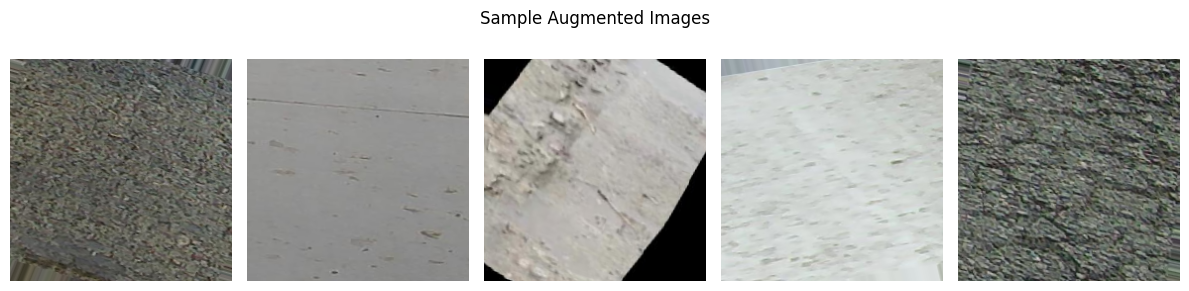

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter

# Path to your dataset
# train_dir = '/kaggle/input/new-dataset/archive/balanced_dataset/train-set-5k'
train_dir = '/content/train-set-5k'

# Get all class folders
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Create lists to hold all file paths and labels
all_files = []
all_labels = []

# Collect all image paths and their corresponding labels
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(train_dir, class_name)
    class_files = [os.path.join(class_name, f) for f in os.listdir(class_dir)
                  if os.path.isfile(os.path.join(class_dir, f))]
    all_files.extend(class_files)
    all_labels.extend([class_name] * len(class_files))

# First, split into train (80%) and temp (20%)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Then split the temp set into validation (10%) and test (10%)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Total files: {len(all_files)}")
print(f"Training files: {len(train_files)} ({len(train_files)/len(all_files)*100:.1f}%)")
print(f"Validation files: {len(val_files)} ({len(val_files)/len(all_files)*100:.1f}%)")
print(f"Test files: {len(test_files)} ({len(test_files)/len(all_files)*100:.1f}%)")

# Visualize class distribution
class_counts = Counter(all_labels)

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Class Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create dataframes for each split
train_df = pd.DataFrame({
    'filename': train_files,
    'class': train_labels
})

val_df = pd.DataFrame({
    'filename': val_files,
    'class': val_labels
})

test_df = pd.DataFrame({
    'filename': test_files,
    'class': test_labels
})

# Create generators
img_height = 224
img_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create flow from dataframe
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(validation_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

# Visualize augmented images
# Get a batch of images from the generator
x_batch, y_batch = next(train_generator)

# Display 5 augmented images
plt.figure(figsize=(12, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle('Sample Augmented Images')
plt.tight_layout()
plt.show()

 ## 3.1.2 Design, Train, and Evaluate a Baseline Model

 Build a simple CNN model with:
 - 3 Convolutional layers (3×3 kernels and ReLU activation) each followed by a 2×2 Max Pooling layer.
 - 3 Dense layers (with 128, 64, and 32 neurons, using ReLU).
 - An output Dense layer with 27 neurons (using softmax).

 Train for 20 epochs with Adam optimizer and sparse categorical crossentropy.


**1. Model Architecture:**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745756224.704704      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,534,363 (169.89 MB)

 Trainable params: 44,534,363 (169.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745756233.726025      77 service.cc:148] XLA service 0x7d505c00b490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745756233.726751      77 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745756234.034088      77 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/3375 ━━━━━━━━━━━━━━━━━━━━ 10:12:54 11s/step - accuracy: 0.0312 - loss: 3.3034

I0000 00:00:1745756237.821380      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1905s 561ms/step - accuracy: 0.1875 - loss: 2.6324 - val_accuracy: 0.3571 - val_loss: 1.9653
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1272s 376ms/step - accuracy: 0.3796 - loss: 1.9118 - val_accuracy: 0.4370 - val_loss: 1.6952
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1290s 381ms/step - accuracy: 0.4455 - loss: 1.6835 - val_accuracy: 0.4661 - val_loss: 1.6253
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1322s 391ms/step - accuracy: 0.4867 - loss: 1.5543 - val_accuracy: 0.4983 - val_loss: 1.5084
Epoch 5/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1330s 393ms/step - accuracy: 0.5131 - loss: 1.4662 - val_accuracy: 0.5164 - val_loss: 1.4701
Epoch 6/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1304s 386ms/step - accuracy: 0.5328 - loss: 1.3897 - val_accuracy: 0.5362 - val_loss: 1.3963
Epoch 7/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1281s 379ms/step - accuracy: 0.5515 - loss: 1.3423 - val_accuracy: 0.5367 - val_loss: 1.4527
Epoch 8/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1303s 385ms/step - accur

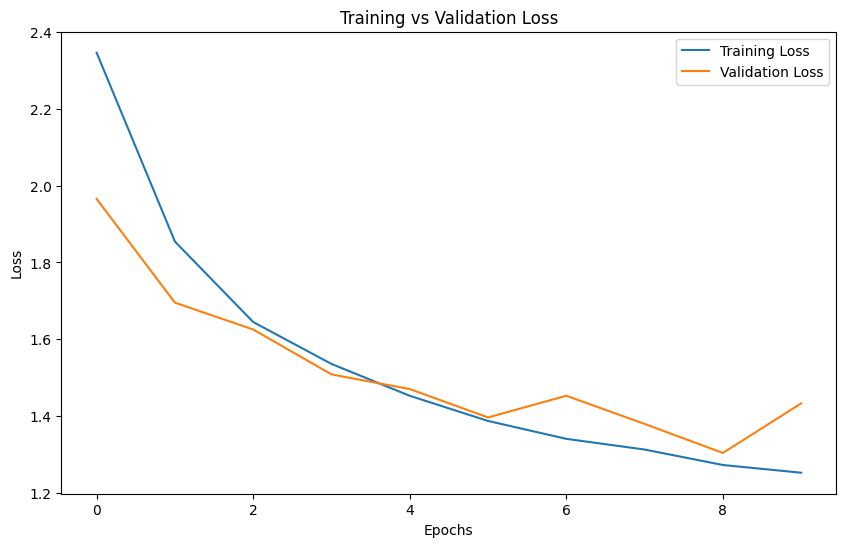

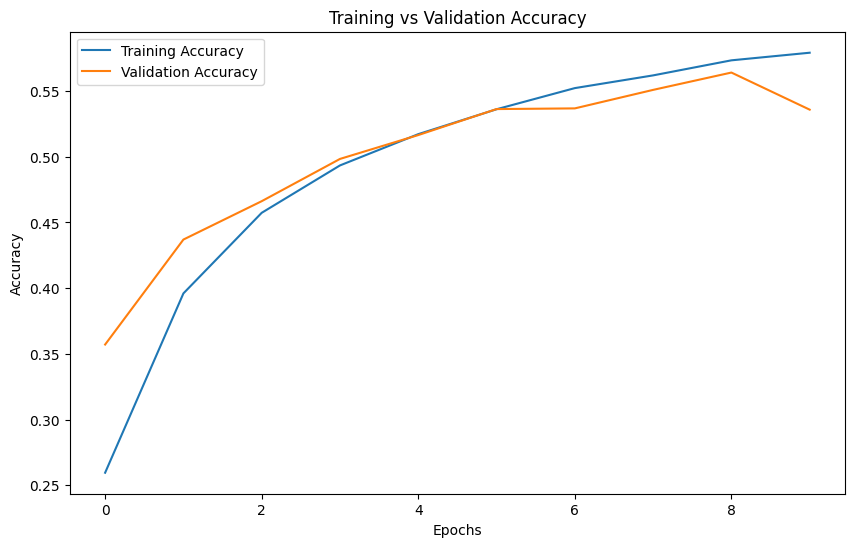

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Model Architecture
# Get the number of classes from the train_generator
num_classes = len(train_generator.class_indices)

baseline_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use the number of classes from the generator
])

baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
baseline_model.summary()

# Model Training
# Simply use the generators created earlier
history_baseline = baseline_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# For accuracy plot as well
plt.figure(figsize=(10, 6))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

**3. Model Evaluation**

3.1 Metrices(classification_report, precision_score, recall_score, f1_score)

In [7]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# 1. Load your saved model
model_base = load_model('/content/baseline_model.h5')

# 2. Make sure the test generator is reset so it starts from the first sample
test_generator.reset()

# 3. Evaluate loss & accuracy directly
loss, accuracy = model_base.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 4. Get true labels and predicted labels
#    - Predict probabilities for each class
y_prob = model_base.predict(test_generator, verbose=1)
#    - Convert to predicted class indices
y_pred = np.argmax(y_prob, axis=1)
#    - True labels from the generator
y_true = test_generator.classes

# 5. Build a list of class names in the correct order
class_names = list(test_generator.class_indices.keys())

# 6. Compute and display the classification report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))



422/422 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.5478 - loss: 1.3804
Test Loss: 1.3726
Test Accuracy: 0.5487
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step

Classification Report:
                       precision    recall  f1-score   support

   dry_asphalt_severe     0.0408    0.0340    0.0371       500
   dry_asphalt_slight     0.0250    0.0300    0.0273       500
   dry_asphalt_smooth     0.0464    0.0320    0.0379       500
  dry_concrete_severe     0.0235    0.0240    0.0237       500
  dry_concrete_slight     0.0412    0.0420    0.0416       500
  dry_concrete_smooth     0.0291    0.0240    0.0263       500
           dry_gravel     0.0299    0.0320    0.0309       500
              dry_mud     0.0413    0.0260    0.0319       500
           fresh_snow     0.0299    0.0380    0.0335       500
                  ice     0.0365    0.0320    0.0341       500
          melted_snow     0.0424    0.0340    0.0377       500
 water_asphalt_severe     0.0183    0.0120    0.0145       

3.2 Inference on a sample test image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


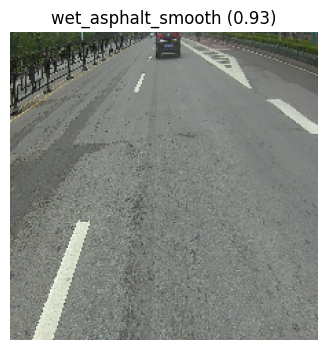

In [11]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model_path = 'baseline_model.h5'
img_path   = '/content/archive/balanced_dataset/test-set/1/2022-06-27 06-59-48-301.jpg'  # path to the single image
img_height = 224
img_width  = 224

# 1. Load your trained model
model = load_model(model_path)

# 2. Load & preprocess the image
img = image.load_img(img_path, target_size=(img_height, img_width))
x   = image.img_to_array(img) / 255.0           # scale to [0,1]
x   = np.expand_dims(x, axis=0)                 # make batch of size 1

# 3. Predict
preds     = model.predict(x)                    # shape (1, num_classes)
pred_idx  = np.argmax(preds[0])                 # index of highest-probability class
pred_prob = preds[0][pred_idx]                  # its probability

# 4. Map index back to class name
# Instead of using model.class_indices, use test_generator.class_indices
class_indices = test_generator.class_indices
# Invert the dictionary to map indices to class names
class_indices = {v: k for k, v in class_indices.items()}
pred_label = class_indices[pred_idx]

# 5. Plot the image with prediction
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_label} ({pred_prob:.2f})")
plt.show()

## 3.1.3 Design, Train , and Evaluate Deeper Architecture with Regularization Layer

 We double the number of convolutional layers (to 6) and add batch normalization and dropout (dropout rate of 0.5) for regularization.


**1. Model Architecture(Adam)**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745488949.087480      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,008,059 (103.03 MB)

 Trainable params: 27,004,603 (103.01 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745488964.939043      97 service.cc:148] XLA service 0x7814e800a5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745488964.940209      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745488965.968668      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/3375 ━━━━━━━━━━━━━━━━━━━━ 4:56 88ms/step - accuracy: 0.0234 - loss: 5.1814   

I0000 00:00:1745488980.149133      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1898s 554ms/step - accuracy: 0.1519 - loss: 3.4121 - val_accuracy: 0.2285 - val_loss: 2.9296 - learning_rate: 1.0000e-04
Epoch 2/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1241s 367ms/step - accuracy: 0.2809 - loss: 2.4248 - val_accuracy: 0.3713 - val_loss: 2.1290 - learning_rate: 1.0000e-04
Epoch 3/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1236s 365ms/step - accuracy: 0.3761 - loss: 1.9781 - val_accuracy: 0.2123 - val_loss: 5.6917 - learning_rate: 1.0000e-04
Epoch 4/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1238s 366ms/step - accuracy: 0.4579 - loss: 1.6726 - val_accuracy: 0.3712 - val_loss: 2.6482 - learning_rate: 1.0000e-04
Epoch 5/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1246s 368ms/step - accuracy: 0.5153 - loss: 1.4885 - val_accuracy: 0.5119 - val_loss: 1.6222 - learning_rate: 1.0000e-04
Epoch 6/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1239s 366ms/step - accuracy: 0.5554 - loss: 1.3379 - val_accuracy: 0.5810 - val_loss: 1.3065 - learning_rate: 1.0000e-04
Epoch 7/15
3375/3375 ━━━━━━━━━━━━

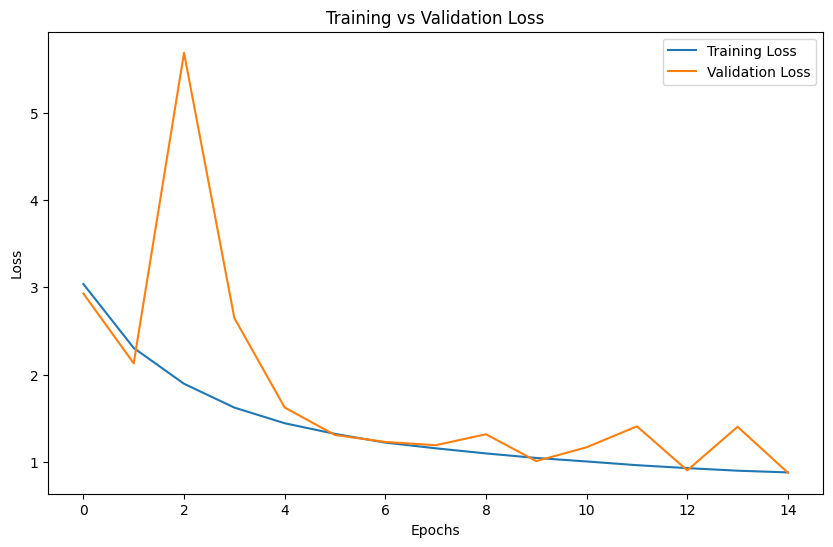

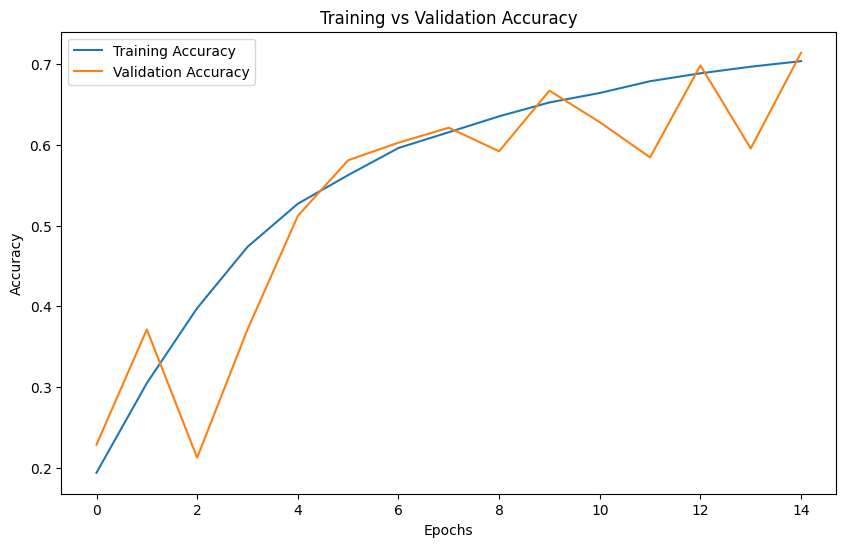

422/422 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.7163 - loss: 0.8713
Validation Accuracy: 0.7142
Validation Loss: 0.8738


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Improved Model Architecture
num_classes = len(train_generator.class_indices)

improved_model = Sequential([
    # First block - same as baseline but with BatchNorm
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second block - increased filters
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third block - even more filters
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth block - deep features
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Classifier
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Use a lower learning rate
optimizer = Adam(learning_rate=0.0001)

improved_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
improved_model.summary()

# Callbacks for improved training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Training with callbacks
history_improved = improved_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Plot Training vs Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# For accuracy plot as well
plt.figure(figsize=(10, 6))
plt.plot(history_improved.history['accuracy'], label='Training Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Evaluate on validation set
val_loss, val_accuracy = improved_model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

In [ ]:
 improved_model.save("deeper_model.h5")

**3. Model Evaluation**

3.1 Metrices(classification_report, precision_score, recall_score, f1_score)

In [12]:
# 1. Load the saved model
model_adam = load_model('/content/deeper_model_adam.h5')

# 2. Make sure the test generator is reset so it starts from the first sample
test_generator.reset()

# 3. Evaluate loss & accuracy directly
loss, accuracy = model_adam.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 4. Get true labels and predicted labels
#    - Predict probabilities for each class
y_prob = model_adam.predict(test_generator, verbose=1)
#    - Convert to predicted class indices
y_pred = np.argmax(y_prob, axis=1)
#    - True labels from the generator
y_true = test_generator.classes

# 5. Build a list of class names in the correct order
class_names = list(test_generator.class_indices.keys())

# 6. Compute and display the classification report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.7316 - loss: 0.8031
Test Loss: 0.7937
Test Accuracy: 0.7324
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step

Classification Report:
                       precision    recall  f1-score   support

   dry_asphalt_severe     0.0423    0.0360    0.0389       500
   dry_asphalt_slight     0.0173    0.0120    0.0142       500
   dry_asphalt_smooth     0.0453    0.0500    0.0475       500
  dry_concrete_severe     0.0408    0.0300    0.0346       500
  dry_concrete_slight     0.0317    0.0360    0.0337       500
  dry_concrete_smooth     0.0417    0.0580    0.0485       500
           dry_gravel     0.0490    0.0380    0.0428       500
              dry_mud     0.0336    0.0300    0.0317       500
           fresh_snow     0.0375    0.0340    0.0357       500
                  ice     0.0480    0.0480    0.0480       500
          melted_snow     0.0538    0.0520    0.0529       500
 water_asphalt_severe     0.0398    0.0380    0.0389       

3.2 Inference on a sample test image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


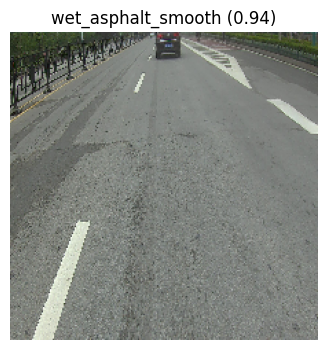

In [14]:
model_path_1 = '/content/deeper_model_adam.h5'
img_path   = '/content/archive/balanced_dataset/test-set/1/2022-06-27 06-59-48-301.jpg'  # path to the single image
img_height = 224
img_width  = 224

# 1. Load your trained model
model = load_model(model_path_1)

# 2. Load & preprocess the image
img = image.load_img(img_path, target_size=(img_height, img_width))
x   = image.img_to_array(img) / 255.0           # scale to [0,1]
x   = np.expand_dims(x, axis=0)                 # make batch of size 1

# 3. Predict
preds     = model.predict(x)                    # shape (1, num_classes)
pred_idx  = np.argmax(preds[0])                 # index of highest-probability class
pred_prob = preds[0][pred_idx]                  # its probability

# 4. Map index back to class name
# Instead of using model.class_indices, use test_generator.class_indices
class_indices = test_generator.class_indices
# Invert the dictionary to map indices to class names
class_indices = {v: k for k, v in class_indices.items()}
pred_label = class_indices[pred_idx]

# 5. Plot the image with prediction
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_label} ({pred_prob:.2f})")
plt.show()

## 3.1.4 Experimentation and Comparative Analysis

**1. Baseline vs. Deeper Model Performance**

The baseline model shows a steady decrease in training and validation loss over 9 epochs, with a final test accuracy of 0.5487 and a test loss of 1.3804. The deeper model, trained over 15 epochs, demonstrates a more complex loss trajectory with some fluctuations in validation loss, but ends with a lower test loss of 0.8031 and a higher test accuracy of 0.7324 compared to the baseline. However, the deeper model's validation accuracy is slightly more volatile, indicating potential overfitting. Both models struggle with low precision, recall, and F1-scores across most classes, as seen in their classification reports. The deeper model shows marginal improvement in overall accuracy but still faces challenges with class imbalances and model generalization. Talking about inferencing on test data(a sample image) the baseline model shows a confidence score of 0.93 with class "wet_asphalt_smooth" whereas the deeper model shows a confidence score of 0.94 with same class of baseline model.

**2. Computational Efficiency**

The baseline model trained over 10 epochs with an average time per epoch of around 385ms/step, completing each epoch in approximately 12-13 minutes. The deeper model, trained over 15 epochs, had a slightly higher average time per epoch of around 367-379ms/step, with each epoch taking roughly 12-13 minutes as well. While both models show similar computational efficiency per epoch, the deeper model required more total training time due to the additional epochs. However, the deeper model demonstrated better validation accuracy improvement over time compared to the baseline.

**3. Optimizer Analysis: SGD vs Adam**

The Adam optimizer demonstrates a lower test loss (0.7937) and higher test accuracy (0.7324) compared to SGD, which has a higher test loss (0.8868) and slightly lower test accuracy (0.6937). Adam shows more significant fluctuations in validation loss and accuracy, indicating potential sensitivity to learning rate adjustments or data distribution. SGD exhibits a smoother decrease in training loss and more consistent validation accuracy, suggesting better generalization in later epochs. However, Adam ultimately achieves better final performance metrics. Both models struggle with class imbalances, as seen in their classification reports, but Adam generally outperforms SGD in precision, recall, and F1-score across most classes. Additionally, the step times per epoch are similar for both optimizers, with Adam averaging around 367-379ms/step and SGD around 366-370ms/step. The learning rate adjustments for SGD (via ReduceLROnPlateau) appear to have a more pronounced effect on validation metrics compared to Adam, which maintains a consistent learning rate. Overall, Adam achieves better final performance with similar computational efficiency, while SGD shows more stable training dynamics but slightly lower final metrics.

**2. Model Architecture(SGD)**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745590473.963098      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,008,059 (103.03 MB)

 Trainable params: 27,004,603 (103.01 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745590485.228952      93 service.cc:148] XLA service 0x79e9c001dbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745590485.229907      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745590485.782179      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/3375 ━━━━━━━━━━━━━━━━━━━━ 4:43 84ms/step - accuracy: 0.0078 - loss: 5.1576       

I0000 00:00:1745590499.458266      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1471s 429ms/step - accuracy: 0.1593 - loss: 3.0029 - val_accuracy: 0.1993 - val_loss: 2.6943 - learning_rate: 0.0100
Epoch 2/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1248s 369ms/step - accuracy: 0.3225 - loss: 2.1323 - val_accuracy: 0.2961 - val_loss: 2.2861 - learning_rate: 0.0100
Epoch 3/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1253s 370ms/step - accuracy: 0.3936 - loss: 1.8898 - val_accuracy: 0.3717 - val_loss: 2.0207 - learning_rate: 0.0100
Epoch 4/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1250s 370ms/step - accuracy: 0.4413 - loss: 1.7135 - val_accuracy: 0.2949 - val_loss: 2.4390 - learning_rate: 0.0100
Epoch 5/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1271s 376ms/step - accuracy: 0.4860 - loss: 1.5677 - val_accuracy: 0.3128 - val_loss: 2.4517 - learning_rate: 0.0100
Epoch 6/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1273s 377ms/step - accuracy: 0.5216 - loss: 1.4604 - val_accuracy: 0.5618 - val_loss: 1.3343 - learning_rate: 0.0100
Epoch 7/15
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 1262s 373ms/ste

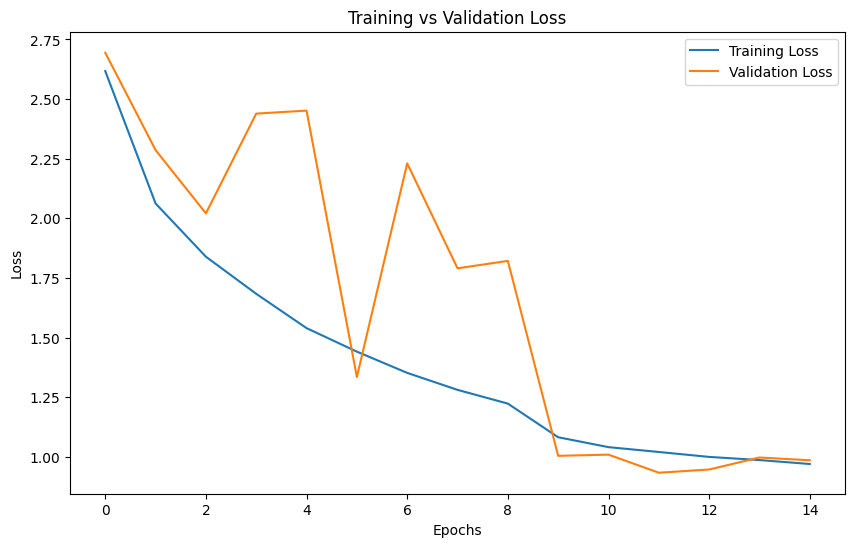

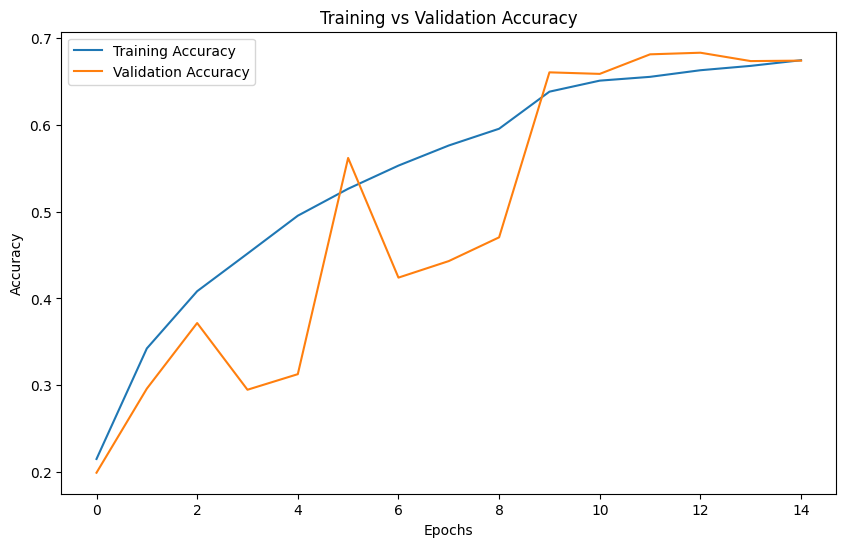

422/422 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.6911 - loss: 0.9272
Validation Accuracy: 0.6830
Validation Loss: 0.9465


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Improved Model Architecture
num_classes = len(train_generator.class_indices)

improved_model = Sequential([
    # First block - same as baseline but with BatchNorm
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second block - increased filters
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third block - even more filters
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth block - deep features
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Classifier
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Use a lower learning rate
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)

improved_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
improved_model.summary()

# Callbacks for improved training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Training with callbacks
history_improved = improved_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Plot Training vs Validation Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# For accuracy plot as well
plt.figure(figsize=(10, 6))
plt.plot(history_improved.history['accuracy'], label='Training Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Evaluate on validation set
val_loss, val_accuracy = improved_model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

In [ ]:
 improved_model.save("deeper_model_SGD.h5")

2.1 Metrices(classification_report, precision_score, recall_score, f1_score)

In [15]:
# 1. Load the saved model
model_sgd = load_model('/content/deeper_model_SGD.h5')

# 2. Make sure the test generator is reset so it starts from the first sample
test_generator.reset()

# 3. Evaluate loss & accuracy directly
loss, accuracy = model_sgd.evaluate(test_generator, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 4. Get true labels and predicted labels
#    - Predict probabilities for each class
y_prob = model_adam.predict(test_generator, verbose=1)
#    - Convert to predicted class indices
y_pred = np.argmax(y_prob, axis=1)
#    - True labels from the generator
y_true = test_generator.classes

# 5. Build a list of class names in the correct order
class_names = list(test_generator.class_indices.keys())

# 6. Compute and display the classification report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

422/422 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6937 - loss: 0.8877
Test Loss: 0.8868
Test Accuracy: 0.6987
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step

Classification Report:
                       precision    recall  f1-score   support

   dry_asphalt_severe     0.0500    0.0400    0.0444       500
   dry_asphalt_slight     0.0327    0.0240    0.0277       500
   dry_asphalt_smooth     0.0382    0.0300    0.0336       500
  dry_concrete_severe     0.0311    0.0220    0.0258       500
  dry_concrete_slight     0.0469    0.0560    0.0510       500
  dry_concrete_smooth     0.0323    0.0440    0.0373       500
           dry_gravel     0.0289    0.0220    0.0250       500
              dry_mud     0.0452    0.0460    0.0456       500
           fresh_snow     0.0201    0.0220    0.0210       500
                  ice     0.0478    0.0460    0.0469       500
          melted_snow     0.0265    0.0240    0.0252       500
 water_asphalt_severe     0.0514    0.0400    0.0450       

2.2 Inference on a sample test image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


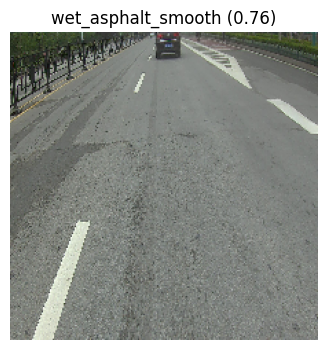

In [16]:
model_path_1 = '/content/deeper_model_SGD.h5'
img_path   = '/content/archive/balanced_dataset/test-set/1/2022-06-27 06-59-48-301.jpg'  # path to the single image
img_height = 224
img_width  = 224

# 1. Load trained model
model = load_model(model_path_1)

# 2. Load & preprocess the image
img = image.load_img(img_path, target_size=(img_height, img_width))
x   = image.img_to_array(img) / 255.0           # scale to [0,1]
x   = np.expand_dims(x, axis=0)                 # make batch of size 1

# 3. Predict
preds     = model.predict(x)                    # shape (1, num_classes)
pred_idx  = np.argmax(preds[0])                 # index of highest-probability class
pred_prob = preds[0][pred_idx]                  # its probability

# 4. Map index back to class name
# Instead of using model.class_indices, use test_generator.class_indices
class_indices = test_generator.class_indices
# Invert the dictionary to map indices to class names
class_indices = {v: k for k, v in class_indices.items()}
pred_label = class_indices[pred_idx]

# 5. Plot the image with prediction
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_label} ({pred_prob:.2f})")
plt.show()

**4. Challenges and Observations**

Challenges were low computation cost, training time was more due to large number of datasets, overfitting and obersevation were we thought pre-trained model would give better performance instead baseline model and deeper model gave good result.

## Task 3.2 - Fine-Tuning a Pre-Trained Model (ResNet50)

We now adapt the ResNet50 model (pre-trained on ImageNet) for 27 classes.

**Model Adaptation:**  
- Remove top layers.
- Add GlobalAveragePooling2D.
- Add a Dense layer (256 neurons, ReLU).
- Add output Dense layer (27 neurons, softmax).

**Freezing Layers:**  
- Freeze the pre-trained layers initially.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

2025-04-28 13:17:53.544648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745846273.734795      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745846273.786503      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**3.2.1 Loading and Adapting a Pre - Trained Model**

In [2]:
!unzip "/content/drive/MyDrive/train-set-5k.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train-set-5k/wet_mud/2022012716253911-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/2022012716285719-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/2022012716305412-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/2022012716305419-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271647526-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271700446-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271704166-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271706426-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271707106-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271708176-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271710406-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271710417-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201271711356-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201272010346-wet-mud.jpg  
  inflating: train-set-5k/wet_mud/202201272021096

In [3]:
# Dataset parameters
# data_dir = '/kaggle/input/new-dataset/archive/balanced_dataset/train-set-5k'
data_dir = '/content/train-set-5k'
img_height, img_width = 224, 224  # Input size for MobileNetV3
batch_size = 16  # Adjust based on your GPU memory
num_classes = 27  # Update with the number of classes in your dataset

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 108000 images belonging to 27 classes.
Found 27000 images belonging to 27 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define your input tensor and apply ResNet-specific preprocessing
inputs = Input(shape=(img_height, img_width, 3))
x = resnet50.preprocess_input(inputs)

# Load pre-trained ResNet50 without the top classification layers
base_model = ResNet50(
    weights='imagenet',    # use ImageNet weights
    include_top=False,     # exclude final FC layer
    input_tensor=x         # feed in your preprocessed Input
)

# Freeze the convolutional base
base_model.trainable = False

# Add your custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)       # stronger regularization
outputs = Dense(num_classes, activation='softmax')(x)

# Assemble the model
model1 = Model(inputs=inputs, outputs=outputs)

# Compile with a low LR for later fine-tuning
model1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


I0000 00:00:1745846379.570854      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,650,651 (94.03 MB)

 Trainable params: 1,062,939 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,  # Start with a few epochs for feature extraction
    callbacks=[early_stop, checkpoint]
)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745846396.054648     103 service.cc:148] XLA service 0x7f56c80033a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745846396.055528     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745846397.330571     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/6750 ━━━━━━━━━━━━━━━━━━━━ 32:15:17 17s/step - accuracy: 0.0000e+00 - loss: 3.9369

I0000 00:00:1745846400.843312     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6750/6750 ━━━━━━━━━━━━━━━━━━━━ 2341s 344ms/step - accuracy: 0.0554 - loss: 3.2903 - val_accuracy: 0.0906 - val_loss: 3.1289
Epoch 2/3
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 1375s 204ms/step - accuracy: 0.0858 - loss: 3.1312 - val_accuracy: 0.1069 - val_loss: 3.0764
Epoch 3/3
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 1337s 198ms/step - accuracy: 0.1050 - loss: 3.0517 - val_accuracy: 0.1100 - val_loss: 3.0647


In [ ]:
model1.save("resnet_FREEZE.h5")

**3.2.2 Model Training and Fine - Tuning**

In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Recompile the model with a lower learning rate
model1.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Number of epochs for fine-tuning
    initial_epoch=history.epoch[-1],  # Start from where feature extraction left off
    callbacks=[early_stop, checkpoint]  # Use the same callbacks for early stopping and checkpointing
)

Epoch 3/5
6750/6750 ━━━━━━━━━━━━━━━━━━━━ 1589s 225ms/step - accuracy: 0.2245 - loss: 3.5320 - val_accuracy: 0.0769 - val_loss: 3.9460
Epoch 4/5
4226/6750 ━━━━━━━━━━━━━━━━━━━━ 8:13 196ms/step - accuracy: 0.4618 - loss: 1.6571

In [ ]:
model1.save("resnet_UNFREEZE.h5")

**3.2.3 Model Evaluation and Prediction**

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.0753 - loss: 3.9514
Validation Loss: 3.9459919929504395
Validation Accuracy: 0.07688888907432556


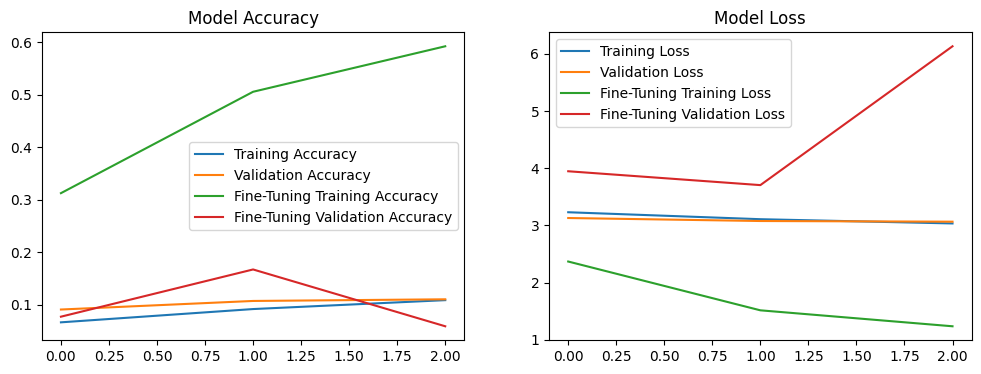

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model1.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuning Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-Tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuning Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

3.1 Metrices(classification_report, precision_score, recall_score, f1_score)

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
# 1. Load your saved ResNet model (freeze or fine-tuned)
model_RESNET = load_model('/content/resnet_unfreeze.h5')

# 2. Ensure the test generator starts from the first batch
test_generator.reset()

# 3. Evaluate overall loss & accuracy
loss, accuracy = model_RESNET.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 4. Obtain predictions & true labels
y_prob = model_RESNET.predict(test_generator, verbose=1)       # (num_samples, num_classes)
y_pred = np.argmax(y_prob, axis=1)                              # Predicted class indices
y_true = test_generator.classes                                # True class indices

# 5. Map indices → class names in the correct order
class_names = list(test_generator.class_indices.keys())

# 6. Print detailed per-class metrics
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

422/422 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.5485 - loss: 1.3769

Test Loss: 1.3726
Test Accuracy: 0.5487
422/422 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step

Classification Report:
                       precision    recall  f1-score   support

   dry_asphalt_severe     0.0408    0.0340    0.0371       500
   dry_asphalt_slight     0.0367    0.0440    0.0400       500
   dry_asphalt_smooth     0.0319    0.0220    0.0260       500
  dry_concrete_severe     0.0313    0.0320    0.0317       500
  dry_concrete_slight     0.0412    0.0420    0.0416       500
  dry_concrete_smooth     0.0316    0.0260    0.0285       500
           dry_gravel     0.0505    0.0540    0.0522       500
              dry_mud     0.0381    0.0240    0.0294       500
           fresh_snow     0.0377    0.0480    0.0423       500
                  ice     0.0434    0.0380    0.0405       500
          melted_snow     0.0424    0.0340    0.0377       500
 water_asphalt_severe     0.0305    0.0200    0.0242      

3.2 Inference on a sample test image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


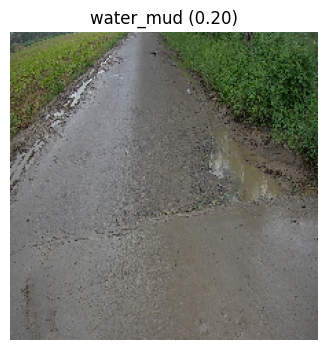

In [12]:
from tensorflow.keras.preprocessing import image
model_path_1 = '/content/resnet_unfreeze.h5'
img_path   = '/content/2022-07-05 15-58-39-73.jpg'  # path to the single image
img_height = 224
img_width  = 224

# 1. Load your trained model
model = load_model(model_path_1)

# 2. Load & preprocess the image
img = image.load_img(img_path, target_size=(img_height, img_width))
x   = image.img_to_array(img) / 255.0           # scale to [0,1]
x   = np.expand_dims(x, axis=0)                 # make batch of size 1

# 3. Predict
preds     = model.predict(x)                    # shape (1, num_classes)
pred_idx  = np.argmax(preds[0])                 # index of highest-probability class
pred_prob = preds[0][pred_idx]                  # its probability

# 4. Map index back to class name
# Instead of using model.class_indices, use test_generator.class_indices
class_indices = test_generator.class_indices
# Invert the dictionary to map indices to class names
class_indices = {v: k for k, v in class_indices.items()}
pred_label = class_indices[pred_idx]

# 5. Plot the image with prediction
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"{pred_label} ({pred_prob:.2f})")
plt.show()

The finetuned pretrained model demonstrates the poorest performance among the three models. Compared to the baseline and deeper models, it shows significantly lower validation accuracy and test accuracy.The classification report highlights its inferiority across all metrics, with drastically lower precision, recall, and F1-scores for nearly every class. This indicates that the finetuned model struggles to generalize effectively and underperforms in capturing the nuances of the data compared to the other models.

## End of Notebook

 This notebook has provided a comprehensive guideline and code for implementing an image classification project using both a CNN built from scratch and a fine-tuned ResNet50 model. Adjust the code as needed for your dataset and experimentation.
